In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
from pymongo import MongoClient
from packaging.version import Version
%matplotlib inline
%config InlineBackend.figure_format = "svg"
print(pd.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.3.4
0.11.2
3.5.0


## Load Data

In [2]:
ms_df = pd.read_csv('data/mindspore.csv')
ms_df['framework'] = 'mindspore'
ms_df['dependent_number'] = ms_df['dependent_number'].fillna(0).astype(int)
pp_df = pd.read_csv('data/paddlepaddle.csv')
pp_df['framework'] = 'paddlepaddle'
pp_df['dependent_number'] = pp_df['dependent_number'].fillna(0).astype(int)
torch_df = pd.read_csv('data/torch.csv')
torch_df['framework'] = 'pytorch'
torch_df['dependent_number'] = torch_df['dependent_number'].fillna(0).astype(int)
tf_df = pd.read_csv('data/tensorflow.csv')
tf_df['framework'] = 'tensorflow'
tf_df['dependent_number'] = tf_df['dependent_number'].fillna(0).astype(int)
all_df = pd.concat([ms_df, pp_df, torch_df, tf_df], ignore_index=True)
print('Toal number of packages in each SC:')
print(len(ms_df), len(pp_df), len(torch_df), len(tf_df), len(all_df))

ms_packages = set(ms_df['name'].unique())
pp_packages = set(pp_df['name'].unique())
torch_packages = set(torch_df['name'].unique())
tf_packages = set(tf_df['name'].unique())
all_packages = set(all_df['name'].unique())
print('Total number of unique packages in each SC:')
print(len(ms_packages), len(pp_packages), len(
    torch_packages), len(tf_packages), len(all_packages))

Toal number of packages in each SC:
13 121 5926 5622 11682
Total number of unique packages in each SC:
13 82 3494 3602 6251


## Structure

- The number of packages in TensorFlow SC and PyTorch SC are almost the same (3494 in PyTorch SC, 3602 in TensorFlow SC).
- TensorFlow publishes the most offcial packages (92 vs 49 (PyTorch) vs 53(PaddlePaddle) vs 7 (MindSpore)).
- PyTorch SC has more packages in layer 2 and layer 3 than TensorFlow SC (2942 vs 2395), while TensorFlow SC has more packages in the last three layers than PyTorch SC (476 vs 123, 137 vs 16, 12 vs 2). It may suggest that TensorFlow SC is maturer than PyTorch SC with some influential packages in the later layers, but it may increase the risk of the packages in the later layers.

In [3]:
print('The number Packages in each layer:')
print('all')
for index, value in all_df.groupby(['layer'])['name'].unique().items():
    print('layer {}:'.format(index), len(value))
print('tensorflow')
for index, value in tf_df.groupby(['layer'])['name'].unique().items():
    print('layer {}:'.format(index), len(value))
print('pytorch')
for index, value in torch_df.groupby(['layer'])['name'].unique().items():
    print('layer {}:'.format(index), len(value))
print('paddlepaddle')
for index, value in pp_df.groupby(['layer'])['name'].unique().items():
    print('layer {}:'.format(index), len(value))
print('mindspore')
for index, value in ms_df.groupby(['layer'])['name'].unique().items():
    print('layer {}:'.format(index), len(value))

The number Packages in each layer:
all
layer 1: 19
layer 2: 5166
layer 3: 3261
layer 4: 564
layer 5: 149
layer 6: 14
tensorflow
layer 1: 13
layer 2: 2395
layer 3: 1626
layer 4: 476
layer 5: 137
layer 6: 12
pytorch
layer 1: 1
layer 2: 2942
layer 3: 1948
layer 4: 123
layer 5: 16
layer 6: 2
paddlepaddle
layer 1: 2
layer 2: 72
layer 3: 23
layer 4: 2
mindspore
layer 1: 3
layer 2: 10


- The package with the most dependent packages in PyTorch SC and TensorFlow SC is torchvision and tensorboard with 990 and 395 dependents respectively.
- The packages with the 10 most dependent packages in TensorFlow SC are most official packages (7 in TensorFlow SC and 5 in PyTorch SC).

In [80]:
d1 = torch_df[['name', 'dependent_number']].drop_duplicates().sort_values(by=['dependent_number'], ascending=False)
d2 = tf_df[['name', 'dependent_number']].drop_duplicates().sort_values(by=['dependent_number'], ascending=False)
d3 = pd.concat([pd.DataFrame({'PT packages': d1.head(11)['name'].values, 'PT Dependent Number': d1.head(11)['dependent_number'].values}), 
              pd.DataFrame({'TF packages': d2.head(11)['name'].values, 'TF Dependent Number': d2.head(11)['dependent_number'].values})], axis=1)
d3.head(11)

,PT packages,PT Dependent Number,TF packages,TF Dependent Number
0,torch,2920,tensorflow,2196
1,torchvision,990,tensorboard,395
2,pytorch-lightning,229,pytorch-lightning,229
3,fastai,88,streamlit,206
4,torchaudio,81,Keras,197
5,torchtext,80,tensorflow-gpu,194
6,torchmetrics,51,tensorflow-probability,155
7,timm,47,tensorflow-estimator,145
8,allennlp,47,tensorflow-addons,118
9,stanza,46,tensorflow-hub,106


In [71]:
import numpy as np
# Code from https://stackoverflow.com/a/61154922/11332158
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))
gini_coefficient(d1[d1['dependent_number'] > 0]['dependent_number'].iloc[1:]), gini_coefficient(
    d2[d2['dependent_number'] > 0]['dependent_number'].iloc[1:])

(0.7754419200911616, 0.7778995978064899)

- The dependency relationship in TensorFlow SC is more complex than PyTorch SC (15 kinds of cross-layer projects vs 9 kinds of cross-layer projects).
- The number of layer2-3 packages is almost the same with that of layer2-only packages in PyTorch SC (1417 vs 1483) and the the number of layer2-3 packages is almost the half of tha of layer2-only packages in TensorFlow SC (771 vs 1560). These layer2-3 packages mainly depend on torchvision (939) and pytorch-lightning (188).

In [4]:
print('SC Structure:')
def apply_func(x):
    res = tuple(set(x))
    if res == (1, 3):
        return (1,)
    return res
print('all')
print(all_df[['name', 'layer']].drop_duplicates().groupby(['name'])[
      'layer'].apply(apply_func).to_frame().reset_index().groupby(['layer']).count())
print('tensorflow')
print(tf_df[['name', 'layer']].drop_duplicates().groupby(['name'])[
      'layer'].apply(apply_func).to_frame().reset_index().groupby(['layer']).count())
print('pytorch')
print(torch_df[['name', 'layer']].drop_duplicates().groupby(['name'])[
      'layer'].apply(apply_func).to_frame().reset_index().groupby(['layer']).count())
print('paddlepaddle')
print(pp_df[['name', 'layer']].drop_duplicates().groupby(['name'])[
      'layer'].apply(apply_func).to_frame().reset_index().groupby(['layer']).count())
print('mindspore')
print(ms_df[['name', 'layer']].drop_duplicates().groupby(['name'])[
      'layer'].apply(apply_func).to_frame().reset_index().groupby(['layer']).count())


SC Structure:
all
              name
layer             
(1,)            19
(2,)          2859
(2, 3)        1941
(2, 3, 4)      249
(2, 3, 4, 5)    62
(2, 3, 5)       29
(2, 3, 6)        3
(2, 4)          21
(2, 5)           2
(3,)           795
(3, 4)         135
(3, 4, 5)       14
(3, 4, 5, 6)     2
(3, 5)          15
(3, 6)           1
(4,)            72
(4, 5)           7
(4, 6)           2
(5,)            17
(5, 6)           1
(6,)             5
tensorflow
              name
layer             
(1,)            13
(2,)          1560
(2, 3)         771
(2, 3, 4)       25
(2, 3, 4, 5)     3
(2, 3, 5)        6
(2, 3, 6)        2
(2, 4)          24
(2, 4, 5)        1
(2, 5)           3
(3,)           712
(3, 4)          79
(3, 4, 5)        7
(3, 4, 5, 6)     1
(3, 5)           7
(4,)           272
(4, 5)          63
(4, 6)           1
(5,)            44
(5, 6)           2
(6,)             6
pytorch
              name
layer             
(1,)             1
(2,)          1483
(2, 3)       

In [99]:
d1 = torch_df[(torch_df['layer'] == 3) & (torch_df['name'].isin(torch_df[torch_df['layer'] == 2]['name']))].groupby(
    ['dependency']).size().sort_values(ascending=False).to_frame().reset_index()
d1 = d1.rename(columns={'dependency': 'PT packages', 0: 'PT dependent count'})
d2 = tf_df[(tf_df['layer'] == 3) & (tf_df['name'].isin(tf_df[tf_df['layer'] == 2]['name']))].groupby(
    ['dependency']).size().sort_values(ascending=False).to_frame().reset_index()
d2 = d2.rename(columns={'dependency': 'TF packages', 0: 'TF dependent count'})
pd.concat([d1.head(10), d2.head(10)], axis=1)

,PT packages,PT dependent count,TF packages,TF dependent count
0,torchvision,939,Keras,164
1,pytorch-lightning,188,tensorboard,153
2,torchaudio,77,tensorflow-probability,142
3,torchtext,73,tensorflow-estimator,132
4,torchmetrics,46,tensorflow-addons,109
5,pytorch-ignite,37,tensorflow-hub,99
6,fastai,37,tensorflow-datasets,58
7,pytorch-transformers,31,tensorflow-text,40
8,pytorch-pretrained-bert,30,seqeval,27
9,timm,29,keras-tuner,24


## Common Packages

In [5]:
def common_packages(dfs: list):
    df1 = dfs[0]
    pkgs1 = set(df1['name'].unique())
    res = pd.DataFrame()
    for i, df2 in enumerate(dfs[1:]):
        tmp_pkgs = set(df2['name'].unique())
        common_packages = list(pkgs1.intersection(tmp_pkgs))
        r1 = df1[df1['name'].isin(common_packages)]
        r2 = df2[df2['name'].isin(common_packages)]
        res = pd.concat([res, r1, r2])
    return res


MindSpore SC only share one package (i.e., READ-mindspore) with only one of the other SCs, i.e., PyTorch SC. 

In [6]:
ms_common = common_packages([ms_df, pp_df, torch_df, tf_df])
ms_common


,name,summary,home_page,project_urls,download_url,layer,dependent_number,dependency,framework
11,READ-mindspore,Unsupervised Anomaly Localization Toolbox and ...,https://git.openi.org.cn/OpenI/READ_mindspore,[],NaN,2,0,mindspore,mindspore
3252,READ-mindspore,Unsupervised Anomaly Localization Toolbox and ...,https://git.openi.org.cn/OpenI/READ_mindspore,[],NaN,3,0,kornia,pytorch


PaddlePaddle SC is closer to TensorFlow SC, which shares 9 packages with PyTorch SC and 22 packages with TensorFlow SC. Notably, The 22 packages involve several key official packages such as paddlehub, paddlenlp, parl.
It may be because that PaddlePaddle was initially released at Aug 2016, behind the first release of TensorFlow but before that of PyTorch. The three SCs share 8 packages.

In [106]:
pp_common = common_packages([pp_df, torch_df, tf_df])
print(pp_packages.intersection(torch_packages), len(pp_packages.intersection(torch_packages)))
print(pp_packages.intersection(tf_packages), len(pp_packages.intersection(tf_packages)))
print(pp_packages.intersection(torch_packages).intersection(tf_packages), len(pp_packages.intersection(torch_packages).intersection(tf_packages)))
print(pp_df.groupby(['name'])['dependent_number'].max().sort_values(ascending=False).head(20))
pp_common


{'sabhi-utils', 'idsegmenter', 'paddleocr-sabhi', 'sabhidoctools', 'id-segmenter', 'matatron', 'qashi', 'paddletools', 'sabhixreader'} 9
{'idsegmenter', 'paddleocr-sabhi', 'appzoo', 'rasa-contrib', 'sabhiocr-server', 'pydp', 'qashi', 'paddlexrest', 'ivystar', 'paddle-parakeet', 'sabhiocr-module', 'parl', 'paddle-tokenizer', 'paddlex', 'paddlehub', 'paddlefsl', 'sabhidoctools', 'id-segmenter', 'paddlenlp', 'sabhi-utils', 'matatron', 'sabhixreader'} 22
{'sabhi-utils', 'idsegmenter', 'paddleocr-sabhi', 'sabhidoctools', 'id-segmenter', 'matatron', 'qashi', 'sabhixreader'} 8
name
paddlepaddle             28
paddlepaddle-gpu         10
sabhi-utils               6
paddlehub                 3
recordio                  2
paddle-serving-app        2
paddleocr                 2
paddlenlp                 2
paddle-serving-client     2
paddleseg                 2
paddlex                   1
pgl                       1
paddle2onnx               1
bert-serving              1
ivystar                   

,name,summary,home_page,project_urls,download_url,layer,dependent_number,dependency,framework
30,paddleocr-sabhi,Package to test the Awesome PaddleOCR,NaN,[],https://github.com/PaddlePaddle/PaddleOCR.git,2,1,NaN,paddlepaddle
59,idsegmenter,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,2,0,paddlepaddle,paddlepaddle
60,matatron,Document Verifier,NaN,[],NaN,2,0,paddlepaddle,paddlepaddle
71,paddleocr-sabhi,Package to test the Awesome PaddleOCR,NaN,[],https://github.com/PaddlePaddle/PaddleOCR.git,2,1,paddlepaddle,paddlepaddle
75,qashi,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,2,0,paddlepaddle,paddlepaddle
...,...,...,...,...,...,...,...,...,...
5504,idsegmenter,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,5,0,sabhi-utils,tensorflow
5505,matatron,Document Verifier,NaN,[],NaN,5,0,sabhi-utils,tensorflow
5506,qashi,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,5,0,sabhi-utils,tensorflow
5507,sabhidoctools,Document Verifier,NaN,[],NaN,5,0,sabhi-utils,tensorflow


In [121]:
print(pp_common[pp_common['framework'] == 'tensorflow'].groupby(['dependency']).size().sort_values(ascending=False))
pp_common[pp_common['dependency'] == 'midv500models']

dependency
sabhi-utils                      6
midv500models                    4
iglovikov-helper-functions       4
paddlehub                        3
tensorflow                       3
tensorboard                      3
tb-nightly                       2
paddlenlp                        2
seqeval                          2
tensorflow-model-optimization    1
tensorflow-metadata              1
tensorflow-hub                   1
tensorflow-estimator             1
tensorflow-datasets              1
tensorflow-addons                1
tensorflow-serving-client        1
tf-models-official               1
Keras                            1
seq2annotation                   1
streamlit                        1
MicroTokenizer                   1
rasa                             1
paddlex                          1
paddleocr-sabhi                  1
paddlefsl                        1
object-detection                 1
keras-model-specs                1
ivystar                          1
g2p-en   

,name,summary,home_page,project_urls,download_url,layer,dependent_number,dependency,framework
5325,idsegmenter,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,3,0,midv500models,pytorch
5326,paddleocr-sabhi,Package to test the Awesome PaddleOCR,NaN,[],https://github.com/PaddlePaddle/PaddleOCR.git,3,1,midv500models,pytorch
5327,qashi,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,3,0,midv500models,pytorch
5328,sabhi-utils,Self rolled utils to be used with the Sabhi OCR,NaN,[],NaN,3,0,midv500models,pytorch
5470,idsegmenter,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,5,0,midv500models,tensorflow
5471,paddleocr-sabhi,Package to test the Awesome PaddleOCR,NaN,[],https://github.com/PaddlePaddle/PaddleOCR.git,5,1,midv500models,tensorflow
5472,qashi,Self Rolled ID Document Segmenter works for ID...,NaN,[],NaN,5,0,midv500models,tensorflow
5473,sabhi-utils,Self rolled utils to be used with the Sabhi OCR,NaN,[],NaN,5,6,midv500models,tensorflow


- PyTorch SC and TensorFlow SC share 916 packages, takes more than 1/4 packages in the two SCs.
- If attributing a package to the layer it firstly appears, these common packages mainly concentrate on the second layer in the PyTorch SC (717). These common packages in the second layer of PyTorch SC distribute over the second, third, and fourth layer of TensorFlow SC.
- Common packages that firstly appear in the third layer of TensorFlow SC mainly depend on tensorboard (255/300).
- Common packages that firstly appear in the fourth layer of TensorFlow SC mainly depend on pytorch-lightning (229/296) and allennlp(47/296), which both depend on tensorboard.

In [8]:
torch_common = common_packages([torch_df, tf_df])
print(len(torch_common.name.unique()))
torch_common


916


,name,summary,home_page,project_urls,download_url,layer,dependent_number,dependency,framework
7,lightning-bolts,PyTorch Lightning Bolts is a community contrib...,https://github.com/PyTorchLightning/lightning-...,"['Bug Tracker, https://github.com/PyTorchLight...",https://github.com/PyTorchLightning/lightning-...,2,4,NaN,pytorch
9,lightning-flash,"Flash is a framework for fast prototyping, fin...",https://github.com/PyTorchLightning/lightning-...,"['Bug Tracker, https://github.com/PyTorchLight...",https://github.com/PyTorchLightning/lightning-...,2,3,NaN,pytorch
10,lightning-transformers,PyTorch Lightning Transformers.,https://github.com/PyTorchLightning/lightning-...,"['Bug Tracker, https://github.com/PyTorchLight...",https://github.com/PyTorchLightning/lightning-...,2,0,NaN,pytorch
15,pytorch-lightning,PyTorch Lightning is the lightweight PyTorch w...,https://github.com/PyTorchLightning/pytorch-li...,"['Bug Tracker, https://github.com/PyTorchLight...",https://github.com/PyTorchLightning/pytorch-li...,2,229,NaN,pytorch
16,pytorch-lightning-bolts,PyTorch Lightning Bolts is a community contrib...,https://github.com/PyTorchLightning/lightning-...,"['Bug Tracker, https://github.com/PyTorchLight...",https://github.com/PyTorchLightning/lightning-...,2,7,NaN,pytorch
...,...,...,...,...,...,...,...,...,...
5615,pre-ai-python,Microsoft AI Python Package,https://github.com/microsoft/ai-python,"['Code, https://github.com/microsoft/ai-python...",NaN,6,0,azureml-pipeline,tensorflow
5618,pangeamt-tea,TEA - Translation Engine Architect,NaN,[],NaN,6,0,nteu-translation-engine,tensorflow
5619,ai-python,Microsoft AI Python Package,https://github.com/microsoft/ai-python,"['Code, https://github.com/microsoft/ai-python...",NaN,6,0,azureml-contrib-automl-pipeline-steps,tensorflow
5620,pre-ai-python,Microsoft AI Python Package,https://github.com/microsoft/ai-python,"['Code, https://github.com/microsoft/ai-python...",NaN,6,0,azureml-contrib-automl-pipeline-steps,tensorflow


[[246, 246, 207, 17, 1],
 [37, 52, 83, 15, 1],
 [0, 2, 6, 1, 0],
 [1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0]]


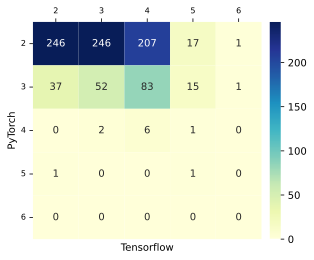

In [9]:
## The first layer a package appears in the two SC
grp = torch_common.groupby(['framework', 'name'])['layer'].min()
a = [[0 for i in range(5)] for j in range(5)]
for p in torch_common.name.unique():
    t1 = grp.loc[('pytorch', p)]
    t2 = grp.loc[('tensorflow', p)]
    a[t1 - 2][t2 - 2] = a[t1 - 2][t2 - 2] + 1
pprint(a)
x = [2, 3, 4, 5, 6]
y = [2, 3, 4, 5, 6]
d = pd.DataFrame(data=a, index=x, columns=y)
fig, ax = plt.subplots(figsize=(5, 4))
g = sns.heatmap(d, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={"pad": 0.03})
g.set_xlabel('Tensorflow')
g.set_ylabel('PyTorch')
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=8, ha='center')
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.xaxis.set_ticks_position('top')
plt.savefig('figures/torch_tf_overlap_min.pdf', bbox_inches='tight')

In [125]:
torch_common[(torch_common['framework'] == 'tensorflow') & (torch_common['layer'] == 3)][['name', 'dependency']].drop_duplicates().groupby(
    ['dependency']).size().sort_values(ascending=False).head(10)

dependency
tensorboard               255
tensorflow-estimator       46
seqeval                    36
streamlit                  26
tensorflow-probability     15
keras2onnx                 15
cornac                     14
tensorflow-hub             13
tensorflow-addons          10
Keras                       9
dtype: int64

In [126]:
torch_common[(torch_common['framework'] == 'tensorflow') & (torch_common['layer'] == 4)][['name', 'dependency']].drop_duplicates().groupby(
    ['dependency']).size().sort_values(ascending=False).head(10)

dependency
pytorch-lightning             229
allennlp                       47
iglovikov-helper-functions      9
simpletransformers              8
monai                           8
gym-unity                       7
snorkel                         7
OpenNMT-py                      5
nemo-toolkit                    5
aif360                          5
dtype: int64

In [138]:
torch_common[torch_common['name'] == 'cornac']

,name,summary,home_page,project_urls,download_url,layer,dependent_number,dependency,framework
649,cornac,A collection of recommendation algorithms and ...,https://cornac.preferred.ai/,[],https://github.com/PreferredAI/cornac/archive/...,2,14,torch,pytorch
651,cornac,A collection of recommendation algorithms and ...,https://cornac.preferred.ai/,[],https://github.com/PreferredAI/cornac/archive/...,2,14,tensorflow,tensorflow


[[68, 102, 7, 0, 0],
 [66, 243, 276, 98, 4],
 [1, 8, 22, 17, 0],
 [0, 0, 0, 3, 1],
 [0, 0, 0, 0, 0]]


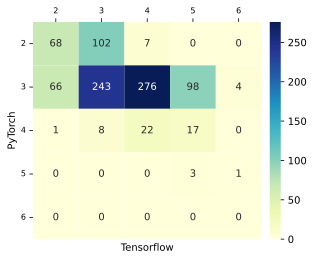

In [10]:
## The last layer a package appears in the two SC
grp = torch_common.groupby(['framework', 'name'])['layer'].max()
a = [[0 for i in range(5)] for j in range(5)]
for p in torch_common.name.unique():
    t1 = grp.loc[('pytorch', p)]
    t2 = grp.loc[('tensorflow', p)]
    a[t1 - 2][t2 - 2] = a[t1 - 2][t2 - 2] + 1
pprint(a)
x = [2, 3, 4, 5, 6]
y = [2, 3, 4, 5, 6]
d = pd.DataFrame(data=a, index=x, columns=y)
fig, ax = plt.subplots(figsize=(5, 4))
g = sns.heatmap(d, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={"pad": 0.03})
g.set_xlabel('Tensorflow')
g.set_ylabel('PyTorch')
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=8, ha='center')
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.xaxis.set_ticks_position('top')
plt.savefig('figures/torch_tf_overlap_max.pdf', bbox_inches='tight')

[[246, 364, 260, 81, 3],
 [190, 326, 362, 115, 5],
 [8, 21, 37, 18, 1],
 [2, 1, 0, 4, 1],
 [0, 0, 0, 0, 0]]


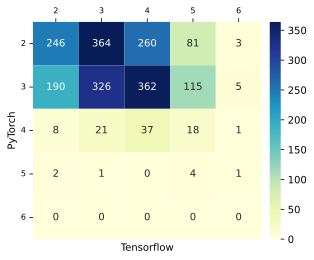

In [11]:
grp = torch_common.groupby(['framework', 'name'])['layer'].apply(set)
a = [[0 for i in range(5)] for j in range(5)]
for p in torch_common.name.unique():
    for t1 in grp.loc[('pytorch', p)]:
        for t2 in grp.loc[('tensorflow', p)]:
            a[t1 - 2][t2 - 2] = a[t1 - 2][t2 - 2] + 1
pprint(a)
x = [2, 3, 4, 5, 6]
y = [2, 3, 4, 5, 6]
d = pd.DataFrame(data=a, index=x, columns=y)
fig, ax = plt.subplots(figsize=(5, 4))
g = sns.heatmap(d, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={"pad": 0.03})
g.set_xlabel('Tensorflow')
g.set_ylabel('PyTorch')
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=8, ha='center')
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.xaxis.set_ticks_position('top')
plt.savefig('figures/torch_tf_overlap_all.pdf', bbox_inches='tight')

Common package statistics

In [11]:
torch_df_filter = torch_df[~torch_df['name'].isin(torch_df[torch_df['layer']==1]['name'])]
torch_pkg_dpt_cnt = torch_df_filter.groupby(['name'])['dependent_number'].max().to_frame().reset_index()
torch_common_pkg_dpt_cnt = torch_pkg_dpt_cnt[torch_pkg_dpt_cnt['name'].isin(torch_common.name.unique())]
torch_pkg_with_dpt = torch_pkg_dpt_cnt[torch_pkg_dpt_cnt.dependent_number > 0]
torch_common_pkg_with_dpt = torch_common_pkg_dpt_cnt[torch_common_pkg_dpt_cnt.dependent_number > 0]
print("The number of PyTorch packages with dependents: {}, {:.1f}%".format(len(torch_pkg_with_dpt), 
                                                                           100 * len(torch_pkg_with_dpt) / len(torch_pkg_dpt_cnt)))
print("The number of common PyTorch packages with dependents: {}, {:.1f}%".format(len(torch_common_pkg_with_dpt), 
                                                                           100 * len(torch_common_pkg_with_dpt) / len(torch_common_pkg_dpt_cnt)))
tf_df_filter = tf_df[~tf_df['name'].isin(tf_df[tf_df['layer']==1]['name'])]
tf_pkg_dpt_cnt = tf_df_filter.groupby(['name'])['dependent_number'].max().to_frame().reset_index()
tf_common_pkg_dpt_cnt = tf_pkg_dpt_cnt[tf_pkg_dpt_cnt['name'].isin(torch_common.name.unique())]
tf_pkg_with_dpt = tf_pkg_dpt_cnt[tf_pkg_dpt_cnt.dependent_number > 0]
tf_common_pkg_with_dpt = tf_common_pkg_dpt_cnt[tf_common_pkg_dpt_cnt.dependent_number > 0]
print("The number of TensorFlow packages with dependents: {}, {:.1f}%".format(len(tf_pkg_with_dpt), 
                                                                           100 * len(tf_pkg_with_dpt) / len(tf_pkg_dpt_cnt)))
print("The number of common TensorFlow packages with dependents: {}, {:.1f}%".format(len(tf_common_pkg_with_dpt), 
                                                                           100 * len(tf_common_pkg_with_dpt) / len(tf_common_pkg_dpt_cnt)))

The number of PyTorch packages with dependents: 475, 13.6%
The number of common PyTorch packages with dependents: 118, 12.9%
The number of TensorFlow packages with dependents: 477, 13.3%
The number of common TensorFlow packages with dependents: 118, 12.9%


In [133]:
## The distribution of dependent count for torch_df, torch_common and tf_df
torch_summary =torch_pkg_with_dpt.groupby(['dependent_number']).size()
torch_summary.index.name = 'PyTorch'
torch_common_summary =torch_common_pkg_with_dpt.groupby(['dependent_number']).size()
torch_common_summary.index.name = 'PyTorch Common'
tf_summary =tf_pkg_with_dpt.groupby(['dependent_number']).size()
tf_summary.index.name = 'TensorFlow'
tf_common_summary =tf_common_pkg_with_dpt.groupby(['dependent_number']).size()
tf_common_summary.index.name = 'TensorFlow Common'
tmp = pd.concat([torch_summary, torch_common_summary, tf_summary, tf_common_summary], axis=1).fillna(0)
tmp[[0,1 ,2, 3]] = tmp[[0,1 ,2, 3]].astype(int)
tmp.rename(columns={0: 'PyTorch', 1: 'PyTorch Common', 2: 'TensorFlow', 3: 'TensorFlow Common'})

,PyTorch,PyTorch Common,TensorFlow,TensorFlow Common
1,270,70,268,70
2,84,19,64,19
3,30,8,39,8
4,21,4,22,4
5,19,5,19,5
6,6,2,8,2
7,7,3,6,3
8,5,1,5,1
9,4,2,7,2
10,1,0,9,0


- pytorch-lightning, torchmetrics, and allennlp all depend on tensorboard, cornac is about recommender systems. 
- With Mann-Whitney U rank test, the The distribution of the direct dependent number of these common packages have no significant difference with those of all PyTorch SC and TensorFlow SC.

In [137]:
torch_common_pkg_with_dpt.sort_values(by=['dependent_number'], ascending=False).head(20)

,name,dependent_number
2372,pytorch-lightning,229
3144,torchmetrics,51
344,allennlp,47
718,cornac,14
1419,iglovikov-helper-functions,9
1738,mlagents,9
1789,monai,8
1320,gym-unity,7
2753,snorkel,7
2373,pytorch-lightning-bolts,7


In [15]:
from scipy import stats
x1 = torch_pkg_with_dpt['dependent_number']
y1 = torch_common_pkg_with_dpt['dependent_number']
x2 = tf_pkg_with_dpt['dependent_number']
y2 = tf_common_pkg_with_dpt['dependent_number']
stats.ranksums(x1, y1), stats.mannwhitneyu(x1, y1), stats.ranksums(x2, y2), stats.mannwhitneyu(x2, y2), stats.ranksums(x1, x2), stats.mannwhitneyu(x1, x2)

(RanksumsResult(statistic=0.4202499128819073, pvalue=0.6743028955851917),
 MannwhitneyuResult(statistic=28725.0, pvalue=0.6399229584845672),
 RanksumsResult(statistic=0.8666339243114337, pvalue=0.38614261973715047),
 MannwhitneyuResult(statistic=29592.0, pvalue=0.3367375251018484),
 RanksumsResult(statistic=-0.7012165402187762, pvalue=0.48316788909333597),
 MannwhitneyuResult(statistic=110313.0, pvalue=0.43745185335544745))

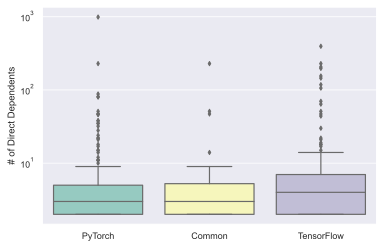

In [16]:
sns.set_theme(context='paper', style="darkgrid")
fig, ax = plt.subplots()
# ax.set_yscale("log")
bp = sns.boxplot(data=[torch_pkg_with_dpt[torch_pkg_with_dpt['dependent_number'] > 1]['dependent_number'], 
                       torch_common_pkg_with_dpt[torch_common_pkg_with_dpt['dependent_number'] > 1]['dependent_number'], 
                       tf_pkg_with_dpt[tf_pkg_with_dpt['dependent_number']>1]['dependent_number'], 
                       ], 
                 palette="Set3", fliersize=3, ax=ax)
bp.set_ylabel("# of Direct Dependents")
bp.set_xticklabels(['PyTorch', 'Common', 'TensorFlow'], fontsize=9)
bp.set_yscale("log")